In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

import esim_torch

Loading images
Loading data to GPU
Generating events
Plotting


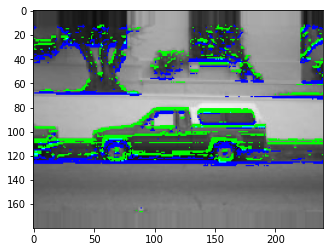

In [4]:
esim = esim_torch.ESIM(contrast_threshold_neg=0.2,
                        contrast_threshold_pos=0.2,
                        refractory_period_ns=0)

print("Loading images")
image_files = sorted(glob.glob("../../esim_py/tests/data/images/images/*.png"))
images = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files])
timestamps_s = np.genfromtxt("../../esim_py/tests/data/images/timestamps.txt")
timestamps_ns = (timestamps_s * 1e9).astype("int64")

log_images = np.log(images.astype("float32") / 255 + 1e-4)

# generate torch tensors
print("Loading data to GPU")
device = "cuda:0"
log_images = torch.from_numpy(log_images).to(device)
timestamps_ns = torch.from_numpy(timestamps_ns).to(device)

# generate events with GPU support
print("Generating events")
events = esim.forward(log_images, timestamps_ns)

# render events 
image = images[0]

print("Plotting")
first_few_events = {k: v[:10000].cpu().numpy() for k,v in events.items()}
image_color = np.stack([image,image,image],-1)
image_color[first_few_events['y'], first_few_events['x'], :] = 0
image_color[first_few_events['y'], first_few_events['x'], first_few_events['p']] = 255

plt.imshow(image_color)
plt.show()